# Logistic Regression: cat or dog?
In this lab you will teach computer to distinguish between images of cats and dogs using Logistic Regression. 
The input dataset consists of 10,000 images manually labeled as ''cats'' and ''dogs''. The original dataset was downloaded from kaggle. 

Download the entire [folder](https://drive.google.com/file/d/1V4pAtGy7VOJQlxM3g8gyDee8h5k7VTSF/view?usp=sharing)  with images and unzip it into your local directory containing input files for this course. Then set the path below to point to this directory.

In [27]:
data_dir = "../datasets/cat_dog_data"

## 1. Building the model

### 1.1. Import all the required libraries. 
If you get an import error on `keras`, run one of the next 2 cells to install `keras` in the current Jupyter kernel, and then rerun the import cell. 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from PIL import Image
from keras import preprocessing

In [ ]:
# Install a conda package (with all its dependencies) in the current Jupyter kernel
# this will work if you have a clean installation of anaconda
import sys

!conda install --yes --prefix {sys.prefix} keras

In [2]:
# Alternatively - install keras package and its dependencies using pip
import sys
!pip3 install --upgrade tensorflow
!python3 -m pip install --upgrade keras

     |████████████████████████████████| 165.2 MB 240 kB/s eta 0:00:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     |████████████████████████████████| 1.3 MB 1.2 MB/s eta 0:00:01
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     |████████████████████████████████| 3.3 MB 363 kB/s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 28.8 MB 608 kB/s eta 0:00:01
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached tensorboard-2.3.0-py3-none-any.whl (6.8 MB)
  Using cached absl_py-0.10.0-py3-none-any.whl (127 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached tensorboard_plugin_wit-1.7.0-py3-none-any.whl (779 kB)
  Using cached google_auth_oauthlib-0.4.1-py2.py3-none-any.whl (18 kB)
  Using cached Markdown-3.2.2-py3-none-any.whl 

### 1.2. Load images
First check if the path to the directory is correct:

In [29]:
import os
cwd = os.getcwd()
os.chdir(cwd)
print(os.listdir(data_dir))

['.DS_Store', 'new_set', 'test_set', 'training_set']


Next create two lists and fill them with the paths to the corresponding images. 

In [30]:
train_cats_files = []
train_path_cats = data_dir +"/training_set/cats/"
for path in os.listdir(train_path_cats):
    if '.jpg' in path:
        train_cats_files.append(os.path.join(train_path_cats, path))
        
train_dogs_files = []
train_path_dogs = data_dir +"/training_set/dogs/"
for path in os.listdir(train_path_dogs):
    if '.jpg' in path:
        train_dogs_files.append(os.path.join(train_path_dogs, path))
        
len(train_cats_files), len(train_dogs_files)

(4000, 4000)

Now we have the paths to each image in the training set.
We need to convert each image into a numpy array. For this we use the preprocessing module in the `keras` library. 

In [31]:
k = 200
sample_dog_file = train_dogs_files[k]
img = preprocessing.image.load_img(sample_dog_file, target_size=(64, 64))
img_array = preprocessing.image.img_to_array(img)


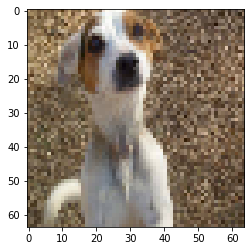

In [32]:
plt.imshow(np.uint8(img_array))

In [33]:
img_array.shape
# print(img_array)

(64, 64, 3)

Each image is represented as a $64*64$ matrix of pixels, and for each pixel we have values of Red, Green, and Blue (RGB). 

### 1.3. Images to numpy arrays
Now we create training sets for cats and for dogs and then concatenate 2 sets into a single `X_train` dataset of features.

In [34]:
# image dimensions: using 32x32 pixels just for speed
d = 32
X_train_orig = np.zeros((8000, d, d, 3), dtype='float32')
for i in range(4000):    
    path = train_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)

for i in range(4000,8000):    
    path = train_dogs_files[i-4000]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_train_orig[i] = preprocessing.image.img_to_array(img)    

X_train_orig.shape

(8000, 32, 32, 3)

### 1.4. Flatten 3D image arrays
Our model requires each object to be a 1D vector of features -
we need to flatten our 3D image arrays.

After reshaping we will have,
$d*d*3$ features as a single array for each picture in the training set (8000 pics),

In [35]:
X_train = X_train_orig.reshape(8000,-1)
print(X_train[0])
X_train.shape

[33. 37. 40. ... 50. 35. 30.]


(8000, 3072)

### 1.5. Create class labels
Now we need to create the corresponding class label vectors. We will mark the cats as class 1, and the dogs as class 0 (not cats).

In [36]:
Y_train_orig = np.ones((4000,)) # 1 - 4000 are cat pictures so our label is 1
Y_train_orig = np.concatenate((Y_train_orig, np.zeros((4000,)))) # 4000 - 8000 are dog pictures so our label is 0
Y_train = Y_train_orig.reshape(-1)
print("At position 3 should be a cat:", Y_train[3])
print("At position 4002 should be a dog:", Y_train[4002])
Y_train.shape

At position 3 should be a cat: 1.0
At position 4002 should be a dog: 0.0


(8000,)

### 1.6. Build the model
We are using the `LogisticRegression` class from `sklearn` package.
<ul>
<li>The <code>random_state</code> parameter tells to shuffle the samples, so the classifier does not see all the cats first, and then the dogs. Specifying  the `random_state` value ensures that the algorithm starts from the same random seed and produces reproducible results.</li> 
<li>The <code>max_iter</code> parameter tells algorithm to stop even if it did not reach the thrreshold for convergence yet.</li>
    <li>In the <code>solver</code> parameter you can specify the algorithm which you want to use.</li>
</ul>

You can read more about the parameters of  `LogisticRegression` model [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [55]:
from sklearn import linear_model

algorithms = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] # default='lbfgs'
logreg = linear_model.LogisticRegression(solver=algorithms[4], random_state = 20, max_iter = 500)
logreg.fit (X_train, Y_train)

/Users/JustinY./opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(max_iter=500, random_state=20, solver='saga')

The score of the logistic regression classifier is simply a percentage of correctly predicted data points. This measure is called the **accuracy** of the model.

In [56]:
acc_train = logreg.score(X_train, Y_train)
print("train accuracy: {} ".format(acc_train))

train accuracy: 0.75475 


## 2. Lab Task 1: Model evaluation  \[60%\]
Obviously, we are much more interested to see how our model performs on the test data. To create a test set, repeat steps 1.2-1.5 for the test_set folder.

### 2.1. Load images

In [57]:
test_cats_files = []
test_path_cats = data_dir +"/test_set/cats/"
for path in os.listdir(test_path_cats):
    if '.jpg' in path:
        test_cats_files.append(os.path.join(test_path_cats, path))
        
test_dogs_files = []
test_path_dogs = data_dir +"/test_set/dogs/"
for path in os.listdir(test_path_dogs):
    if '.jpg' in path:
        test_dogs_files.append(os.path.join(test_path_dogs, path))

len(test_cats_files), len(test_dogs_files)

(1000, 1000)

### 2.2. Images to numpy arrays

In [58]:
X_test_orig = np.zeros((2000, d, d, 3), dtype='float32')  
for i in range(1000):    
    path = test_cats_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)

for i in range(1000,2000):    
    path = test_dogs_files[i-1000]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_test_orig[i] = preprocessing.image.img_to_array(img)    

X_test_orig.shape

(2000, 32, 32, 3)

### 2.3. Flatten 3D image arrays

In [59]:
X_test = X_test_orig.reshape(2000,-1)
print(X_test[0])
X_test.shape

[240. 249. 244. ... 185. 194. 201.]


(2000, 3072)

### 2.4. Create class labels

In [60]:
Y_test = np.ones((1000,))
Y_test = np.concatenate((Y_test, np.zeros((1000,))))
Y_test = Y_test.reshape(-1)
print("At position 3 should be a cat:", Y_test[3])
print("At position 1002 should be a dog:", Y_test[1002])

Y_test.shape

At position 3 should be a cat: 1.0
At position 1002 should be a dog: 0.0


(2000,)

### 2.5. Accuracy for the test set

In [61]:
acc_test = logreg.score(X_test, Y_test)
print("test accuracy: {} ".format(acc_test))

test accuracy: 0.6 


### 2.6. Improve the model
If the predictive power of the classifier is too low, try to improve the model. Below are some suggestions for improving it. Rerun the model after each modification and see if the accuracy of prediction is improved. 

Carefully record the results of your experiments in a separate markdown cell.

<ol>
    <li>Increase value of $d$ (image dimensions) to 64.</li>
    <li>Normalize values in pixel arrays by dividing each value by 255 (max RGB value).</li>
    <li>Use a different model-fitting algorithm.</li>
    <li>Modify default parameters of <code>LogisticRegression</code> class.</li>
    <li>$\ldots$</li>
</ol>

You can stop once you have a good accuracy for the test set (no less than 0.60).

### Stuff I did to improve my model:
###### The original accuracy of my model is 0.5745

<ol>
    <li> After increasing the value of d to 64, the accuracy went down to 0.54, so I discarded this change.</li>
    <li> After trying a couple model-fitting algorithms, and going with 'saga', and decreasing the max_iter to 500, the accuracy went up to 0.5995 </li>
    <li> After changing random_state to 20, the accuracy went up to 0.6</li>
</ol>

### 2.7. Predict random cats
Find a random image of a cat and another of a dog, and test your model to predict it. Follow all the steps to convert two images into an array of features and then call:

In [64]:
new_files = []
new_files.append(data_dir + "/new_set/cat.jpg")
new_files.append(data_dir + "/new_set/dog.jpg")
print(new_files)

d = 32
X_new = np.zeros((2, d, d, 3), dtype='float32')
for i in range(2):
    path = new_files[i]
    img = preprocessing.image.load_img(path, target_size=(d, d))
    X_new[i] = preprocessing.image.img_to_array(img)
    
X_new = X_new.reshape(2,-1)

Y_new = logreg.predict(X_new)
print(Y_new)
print("The model predicted incorrectly. It predicted both images as dogs.")

['../datasets/cat_dog_data/new_set/cat.jpg', '../datasets/cat_dog_data/new_set/dog.jpg']
[0. 0.]
The model predicted incorrectly. It predicted both images as dogs.


Submit your images with your lab, and specify which prediction did you obtain for each image.

### 2.8. Save model to file
When you are happy with the performance of your model and want to use it to identify cats in the future, save it to file using pickle. An example how to save the model and then reload it can be found [here](
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/).

Test that you can save the model and then load it in the cell below. Put your saved model to your google drive folder and provide the link to it in your notebook submission.

In [65]:
import pickle
filename = "cat_dog_model.sav"
pickle.dump(logreg, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

0.6


# 3. Lab Task 2: Support Vector Machines \[40%\]
First, watch the [video](https://www.youtube.com/watch?v=efR1C6CvhmE&vl=en) about another classifier: Support Vector Machine (SVM).

Next, perform the cat/dog image classification learning using SVM.
Learn about the parameters of the sklearn SVC class [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [68]:
from sklearn.svm import SVC # "Support vector classifier"
svm = SVC(kernel='rbf', C=1E3)
svm.fit(X_train, Y_train)
svm.score(X_test, Y_test)


0.671

SVM is a more powerful classifier than logistic regression. Try to achieve a better accuracy by playing with the algorithm parameters. Report the final values in a new markdown cell below.

### Results of image classification using SVM


Finally, in a newly added markdown cell briefly explain how do you understand the difference between the logistic regression and SVM learning algorithms. Pay a special attention to how these algorithms treat a decision boundary. 

<p>The method of logistic regression and SVM is very different. In logistic regression, the decision boundary is characterized by the probability of some data point being classified as a class to be 0.5 (50%). At the decision boundary, there is an equal chance for the datapoint to be classified as either class. In SVM, the decision boundary is characterized by the line (or hyperplane) that maximizes the margins (which is the distance between the line itself and the 'support vectors'). Support vectors are essentially the datapoints that are closest to the decision boundary (and the points to which the margin is measured from). Especially for a linearly separable dataset, SVM performs really well since the optimal margins are very easily found.  </p>

Copyright &copy; 2020 Marina Barsky. All rights reserved.